Testing different models for provided dataset

Training Logistic Regression...

Logistic Regression Classification Report on Validation Data:

              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.50      0.71      0.59         7

    accuracy                           0.46        13
   macro avg       0.42      0.44      0.41        13
weighted avg       0.42      0.46      0.42        13

Confusion Matrix for Logistic Regression on Validation Data:
[[1 5]
 [2 5]]
Training k-NN...

k-NN Classification Report on Validation Data:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       1.00      0.14      0.25         7

    accuracy                           0.54        13
   macro avg       0.75      0.57      0.46        13
weighted avg       0.77      0.54      0.44        13

Confusion Matrix for k-NN on Validation Data:
[[6 0]
 [6 1]]
Training Decision Tree...

Decision Tree Classi

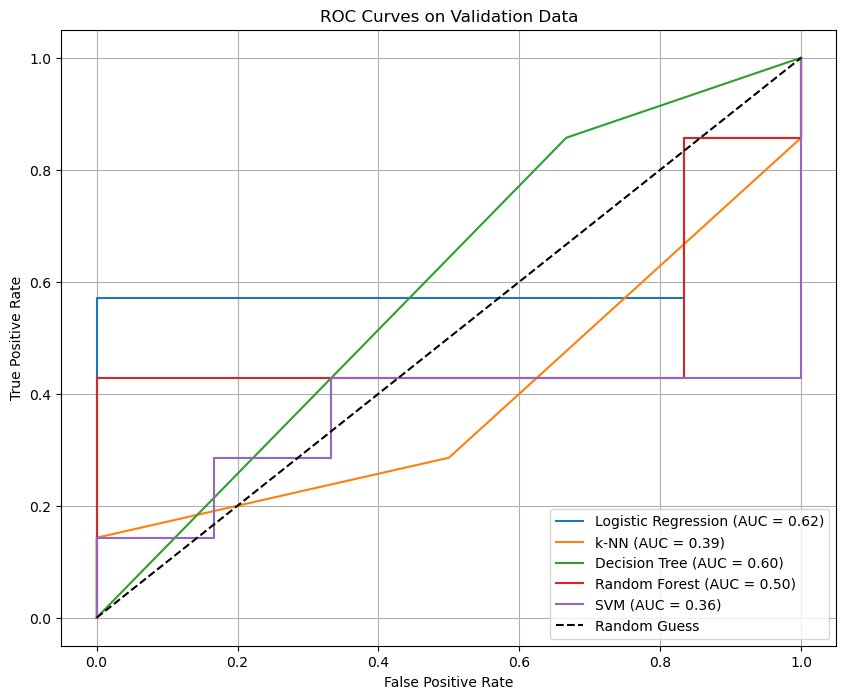


Evaluating models on the test dataset...

Evaluating Logistic Regression on the test data...

Logistic Regression Classification Report on Test Data:

              precision    recall  f1-score   support

           0       0.30      0.50      0.38         6
           1       0.67      0.46      0.55        13

    accuracy                           0.47        19
   macro avg       0.48      0.48      0.46        19
weighted avg       0.55      0.47      0.49        19

Confusion Matrix for Logistic Regression on Test Data:
[[3 3]
 [7 6]]
Evaluating k-NN on the test data...

k-NN Classification Report on Test Data:

              precision    recall  f1-score   support

           0       0.28      0.83      0.42         6
           1       0.00      0.00      0.00        13

    accuracy                           0.26        19
   macro avg       0.14      0.42      0.21        19
weighted avg       0.09      0.26      0.13        19

Confusion Matrix for k-NN on Test Data:
[[ 5 

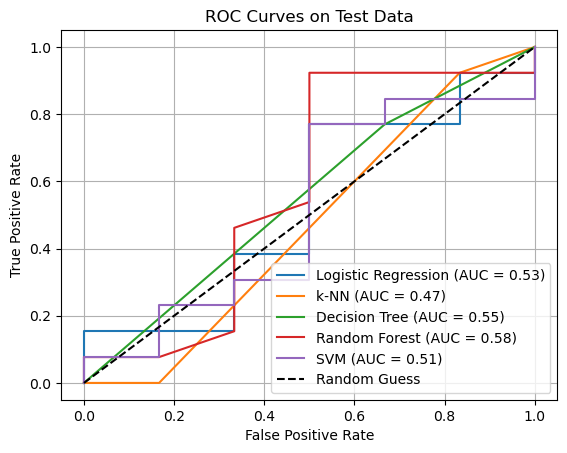

In [2]:
from sklearn.cluster import KMeans
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from a dataset


def load_images(directory, target_size=(64, 64)):
    """
    Loads images from the given directory and normalizes pixel values.

    Args:
        directory (str): Path to the dataset directory.
        target_size (tuple): Target size to resize images (default: (64, 64)).

    Returns:
        np.array: Array of images.
        np.array: Corresponding labels.
    """
    images = []
    labels = []
    for label in ["good", "bad"]:  # Subdirectories for 'good' and 'bad'
        path = os.path.join(directory, label)
        if not os.path.exists(path):
            print(f"Directory {path} not found. Please check the dataset structure.")
            continue
        for file in os.listdir(path):
            try:
                img = load_img(os.path.join(path, file),
                               target_size=target_size)
                img_array = img_to_array(img) / 255.0  # Normalize pixel values
                images.append(img_array)
                labels.append(0 if label == "bad" else 1)
            except Exception as e:
                print(f"Error loading image {file}: {e}")
    return np.array(images), np.array(labels)


# Path to the training dataset
train_data_dir = "reddit_dataset/train"  # Replace with your training folder path

# Load and preprocess training data
X, y = load_images(train_data_dir)

# Ensure data is loaded correctly
if len(X) == 0 or len(y) == 0:
    raise ValueError("No images loaded. Please check the dataset structure and path.")

# Flatten images for traditional ML algorithms
X_flattened = X.reshape(X.shape[0], -1)

# Split the data into training and validation sets with stratified splitting
X_train, X_val, y_train, y_val = train_test_split(
    X_flattened, y, test_size=0.2, random_state=42, stratify=y
)

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear', probability=True)
}

# Train models and evaluate performance on the validation set
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(
        model, "predict_proba") else None

    print(f"\n{name} Classification Report on Validation Data:\n")
    print(classification_report(y_val, y_val_pred))
    print(f"Confusion Matrix for {name} on Validation Data:\n{confusion_matrix(y_val, y_val_pred)}")

    # Store results for later evaluation
    results[name] = {"y_pred": y_val_pred, "y_proba": y_val_proba}

# Plot ROC Curves for validation data
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result["y_proba"] is not None:
        fpr, tpr, _ = roc_curve(y_val, result["y_proba"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves on Validation Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Path to the test dataset
test_data_dir = "reddit_dataset/test"  # Replace with your test folder path

# Load and preprocess test data
X_test_images, y_test = load_images(test_data_dir)
if len(X_test_images) == 0 or len(y_test) == 0:
    raise ValueError(
        "No test images loaded. Please check the test dataset structure.")

X_test_flattened = X_test_images.reshape(X_test_images.shape[0], -1)

# Evaluate models on the test dataset
print("\nEvaluating models on the test dataset...\n")
for name, model in models.items():
    print(f"Evaluating {name} on the test data...")
    y_test_pred = model.predict(X_test_flattened)
    y_test_proba = model.predict_proba(X_test_flattened)[
        :, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name} Classification Report on Test Data:\n")
    print(classification_report(y_test, y_test_pred))
    print(f"Confusion Matrix for {name} on Test Data:\n{confusion_matrix(y_test, y_test_pred)}")

    # Optional: Plot ROC Curve for test data
    if y_test_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot ROC Curves for test data
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves on Test Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Simpler model for Reddit dataset

Found 64 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4688 - loss: 1.2653

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4688 - loss: 1.2653 - val_accuracy: 0.4211 - val_loss: 0.9727
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5625 - loss: 0.9518

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 0.9518 - val_accuracy: 0.5263 - val_loss: 0.8889
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5156 - loss: 1.1319

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5156 - loss: 1.1319 - val_accuracy: 0.5263 - val_loss: 0.8761
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4844 - loss: 1.0355

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4844 - loss: 1.0355 - val_accuracy: 0.4737 - val_loss: 0.8580
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4844 - loss: 1.0767

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4844 - loss: 1.0767 - val_accuracy: 0.5789 - val_loss: 0.8114
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5938 - loss: 0.8501

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5938 - loss: 0.8501 - val_accuracy: 0.6316 - val_loss: 0.8030
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5625 - loss: 0.9793

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 0.9793 - val_accuracy: 0.5263 - val_loss: 0.8018
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5781 - loss: 0.8269

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5781 - loss: 0.8269 - val_accuracy: 0.6316 - val_loss: 0.7911
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6250 - loss: 0.8915

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6250 - loss: 0.8915 - val_accuracy: 0.5789 - val_loss: 0.7865
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5312 - loss: 1.0447 - val_accuracy: 0.5263 - val_loss: 0.7896
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6250 - loss: 0.8535

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6250 - loss: 0.8535 - val_accuracy: 0.5789 - val_loss: 0.7674
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5938 - loss: 0.9621

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5938 - loss: 0.9621 - val_accuracy: 0.5789 - val_loss: 0.7645
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5625 - loss: 1.1859

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 1.1859 - val_accuracy: 0.6316 - val_loss: 0.7551
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5625 - loss: 0.9512

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 0.9512 - val_accuracy: 0.6316 - val_loss: 0.7483
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5312 - loss: 0.9953

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5312 - loss: 0.9953 - val_accuracy: 0.6316 - val_loss: 0.7436
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6250 - loss: 0.8839 - val_accuracy: 0.5789 - val_loss: 0.7466
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6094 - loss: 1.0698 - val_accuracy: 0.6316 - val_loss: 0.7469
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4688 - loss: 1.1478

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4688 - loss: 1.1478 - val_accuracy: 0.6316 - val_loss: 0.7408
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6406 - loss: 0.8401 - val_accuracy: 0.5789 - val_loss: 0.7543
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5781 - loss: 0.8345

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5781 - loss: 0.8345 - val_accuracy: 0.6316 - val_loss: 0.7397
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6719 - loss: 0.8284

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6719 - loss: 0.8284 - val_accuracy: 0.6842 - val_loss: 0.7263
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6406 - loss: 0.8135

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6406 - loss: 0.8135 - val_accuracy: 0.6316 - val_loss: 0.7053
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6875 - loss: 0.7849

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6875 - loss: 0.7849 - val_accuracy: 0.6316 - val_loss: 0.6873
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5938 - loss: 0.9954

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5938 - loss: 0.9954 - val_accuracy: 0.6842 - val_loss: 0.6766
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7969 - loss: 0.6622

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7969 - loss: 0.6622 - val_accuracy: 0.6842 - val_loss: 0.6716
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6406 - loss: 1.0747 - val_accuracy: 0.7368 - val_loss: 0.6814
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6875 - loss: 0.7331 - val_accuracy: 0.6842 - val_loss: 0.6792
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6562 - loss: 0.7654

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6562 - loss: 0.7654 - val_accuracy: 0.6842 - val_loss: 0.6608
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6094 - loss: 0.7747

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6094 - loss: 0.7747 - val_accuracy: 0.6842 - val_loss: 0.6520
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5938 - loss: 0.8257 - val_accuracy: 0.6842 - val_loss: 0.6595
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step - accuracy: 0.6842 - loss: 0.6520
Test Loss: 0.6520, Test Accuracy: 0.6842
Plot saved as training_plot_3_6.png in the 'accuracy' folder.


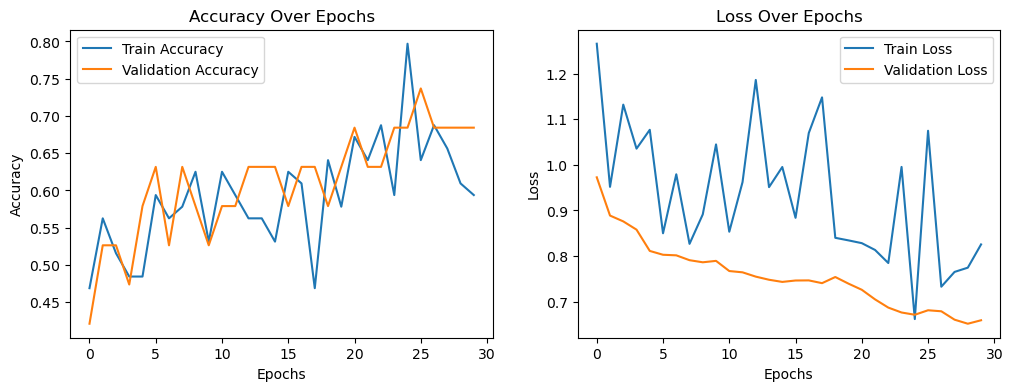

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop


# Paths to the dataset
train_data_dir = "reddit_dataset/train"  # Replace with your training folder path
test_data_dir = "reddit_dataset/test"    # Replace with your test folder path

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Image size for MobileNetV2
BATCH_SIZE = 64                   # Larger batch size for smoother gradients

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,          # Normalize pixel values
    rotation_range=40,          # Increased random rotation
    width_shift_range=0.4,      # Increased horizontal shift
    height_shift_range=0.4,     # Increased vertical shift
    shear_range=0.4,            # Increased shearing transformation
    zoom_range=0.4,             # Increased random zoom
    horizontal_flip=True,       # Flip images horizontally
    fill_mode="nearest"         # Fill in missing pixels
)

# Rescale only for validation/testing (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"  # Binary classification: "good" (1) and "bad" (0)
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Use Pretrained MobileNetV2 as the feature extractor
base_model = MobileNetV2(input_shape=(
    IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # Allow fine-tuning

# Freeze all layers except the last 50 for fine-tuning
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation="relu"),  # Fully connected layer
    Dropout(0.2),                   # Reduced dropout for better balance
    Dense(1, activation="sigmoid")  # Sigmoid for binary classification
])

# Compile the model with RMSprop optimizer and a reduced learning rate
model.compile(
    # RMSprop for more stable training
    optimizer=RMSprop(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Compute class weights if the dataset is imbalanced
class_weights = {0: 1.5, 1: 1.0}  # Adjust weights based on class proportions

# Callbacks for training
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    "reddit_simple_model.h5", monitor="val_loss", save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # Increase epochs for better optimization
    validation_data=test_generator,
    class_weight=class_weights,  # Apply class weights
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Define the folder to save the plots
folder = "accuracy"
os.makedirs(folder, exist_ok=True)  # Ensure the folder exists

# Get the next available number for the filename
existing_files = [f for f in os.listdir(folder) if f.startswith(
    "training_plot") and f.endswith(".png")]
next_number = 1 + max(
    [int(f.split("_")[2].split(".")[0])
     for f in existing_files if f.split("_")[2].split(".")[0].isdigit()],
    default=0
)

# Save the plot with the next number
filename = f"training_plot_3_{next_number}.png"
plt.savefig(os.path.join(folder, filename))

print(f"Plot saved as {filename} in the '{folder}' folder.")

plt.show()

Complex model for reddit dataset

Found 64 images belonging to 2 classes.
Found 19 images belonging to 2 classes.
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4141 - loss: 6.5686

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4375 - loss: 6.5114 - val_accuracy: 0.3684 - val_loss: 6.2301
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3828 - loss: 6.4778

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3958 - loss: 6.4752 - val_accuracy: 0.3684 - val_loss: 6.0902
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5234 - loss: 6.3466

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5000 - loss: 6.3538 - val_accuracy: 0.4211 - val_loss: 6.0315
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5234 - loss: 6.4402

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5208 - loss: 6.4406 - val_accuracy: 0.4211 - val_loss: 5.9907
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5078 - loss: 6.2156

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5000 - loss: 6.2208 - val_accuracy: 0.4211 - val_loss: 5.9783
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4062 - loss: 6.3017

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4167 - loss: 6.3171 - val_accuracy: 0.4737 - val_loss: 5.9557
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5781 - loss: 6.0283

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5729 - loss: 6.0591 - val_accuracy: 0.5789 - val_loss: 5.9240
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4609 - loss: 6.2917

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4583 - loss: 6.2984 - val_accuracy: 0.4737 - val_loss: 5.9130
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4688 - loss: 6.0595

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4896 - loss: 6.0405 - val_accuracy: 0.4737 - val_loss: 5.8993
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6094 - loss: 6.0156

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6042 - loss: 6.0555 - val_accuracy: 0.4737 - val_loss: 5.8992
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5469 - loss: 6.0648

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5521 - loss: 6.0538 - val_accuracy: 0.5263 - val_loss: 5.8825
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5703 - loss: 5.9052

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5521 - loss: 5.9427 - val_accuracy: 0.5263 - val_loss: 5.8555
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6328 - loss: 5.9687

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6458 - loss: 5.9316 - val_accuracy: 0.5263 - val_loss: 5.8512
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5547 - loss: 5.9870

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5625 - loss: 5.9852 - val_accuracy: 0.5263 - val_loss: 5.8453
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6875 - loss: 5.8418

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6875 - loss: 5.8496 - val_accuracy: 0.5263 - val_loss: 5.8392
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6484 - loss: 5.7716

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6354 - loss: 5.7950 - val_accuracy: 0.4737 - val_loss: 5.8262
Epoch 17/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5833 - loss: 5.9801 - val_accuracy: 0.4737 - val_loss: 5.8278
Epoch 18/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.6016 - loss: 6.3089

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5938 - loss: 6.3316 - val_accuracy: 0.4737 - val_loss: 5.8199
Epoch 19/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7656 - loss: 5.6682

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7396 - loss: 5.7068 - val_accuracy: 0.4737 - val_loss: 5.8175
Epoch 20/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4792 - loss: 6.1890 - val_accuracy: 0.4737 - val_loss: 5.8200
Epoch 21/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6328 - loss: 5.8588

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6250 - loss: 5.8634 - val_accuracy: 0.4737 - val_loss: 5.8091
Epoch 22/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5938 - loss: 5.9982

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.5938 - loss: 5.9890 - val_accuracy: 0.4737 - val_loss: 5.8039
Epoch 23/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5078 - loss: 6.1649

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5208 - loss: 6.1284 - val_accuracy: 0.4737 - val_loss: 5.8008
Epoch 24/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4922 - loss: 6.1442

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5000 - loss: 6.1130 - val_accuracy: 0.5263 - val_loss: 5.7976
Epoch 25/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6458 - loss: 5.8590 - val_accuracy: 0.5263 - val_loss: 5.7994
Epoch 26/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6406 - loss: 5.8521

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6354 - loss: 5.8725 - val_accuracy: 0.5263 - val_loss: 5.7941
Epoch 27/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6875 - loss: 5.8568 - val_accuracy: 0.5263 - val_loss: 5.7949
Epoch 28/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6484 - loss: 5.7700

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6354 - loss: 5.8118 - val_accuracy: 0.4737 - val_loss: 5.7938
Epoch 29/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6250 - loss: 5.7041

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6146 - loss: 5.7276 - val_accuracy: 0.4737 - val_loss: 5.7912
Epoch 30/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6641 - loss: 5.8855

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6562 - loss: 5.8961 - val_accuracy: 0.5263 - val_loss: 5.7874
Epoch 31/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5781 - loss: 5.7912

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5729 - loss: 5.8082 - val_accuracy: 0.5789 - val_loss: 5.7856
Epoch 32/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7344 - loss: 5.5941

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7292 - loss: 5.6185 - val_accuracy: 0.5789 - val_loss: 5.7825
Epoch 33/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7344 - loss: 5.6587

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7292 - loss: 5.6770 - val_accuracy: 0.5789 - val_loss: 5.7784
Epoch 34/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7188 - loss: 5.6653 - val_accuracy: 0.5789 - val_loss: 5.7786
Epoch 35/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - loss: 5.7669

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7396 - loss: 5.7819 - val_accuracy: 0.5789 - val_loss: 5.7757
Epoch 36/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6146 - loss: 5.8536 - val_accuracy: 0.5263 - val_loss: 5.7770
Epoch 37/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6354 - loss: 5.8339 - val_accuracy: 0.4737 - val_loss: 5.7831
Epoch 38/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6562 - loss: 5.9911 - val_accuracy: 0.5263 - val_loss: 5.7806
Epoch 39/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5312 - loss: 6.0808 - val_accuracy: 0.5263 - val_loss: 5.7785
Epoch 40/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7083 - loss: 5.9114 - val_accuracy: 0.5263 - val_loss: 5.7770
Epoch 41/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5625 - loss: 5.9921 - val_accuracy: 0.5263 - val_loss: 5.7770
Epoch 42/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6094 - loss: 5.8527

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6042 - loss: 5.8526 - val_accuracy: 0.5263 - val_loss: 5.7713
Epoch 43/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6641 - loss: 5.7438

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6667 - loss: 5.7494 - val_accuracy: 0.5263 - val_loss: 5.7669
Epoch 44/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7188 - loss: 5.7826

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7188 - loss: 5.7798 - val_accuracy: 0.5263 - val_loss: 5.7615
Epoch 45/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5938 - loss: 6.0348 - val_accuracy: 0.5263 - val_loss: 5.7635
Epoch 46/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6875 - loss: 5.7333

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6771 - loss: 5.7639 - val_accuracy: 0.5263 - val_loss: 5.7566
Epoch 47/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7031 - loss: 5.8034

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7083 - loss: 5.7954 - val_accuracy: 0.5263 - val_loss: 5.7566
Epoch 48/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6484 - loss: 5.8923

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6562 - loss: 5.8730 - val_accuracy: 0.5263 - val_loss: 5.7555
Epoch 49/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7188 - loss: 5.7490

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7083 - loss: 5.7494 - val_accuracy: 0.5263 - val_loss: 5.7537
Epoch 50/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6406 - loss: 5.7139

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6354 - loss: 5.7304 - val_accuracy: 0.5263 - val_loss: 5.7488
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step - accuracy: 0.5263 - loss: 5.7488
Test Loss: 5.7488, Test Accuracy: 0.5263
Training plots saved as training_plot_1.png in 'plots'.


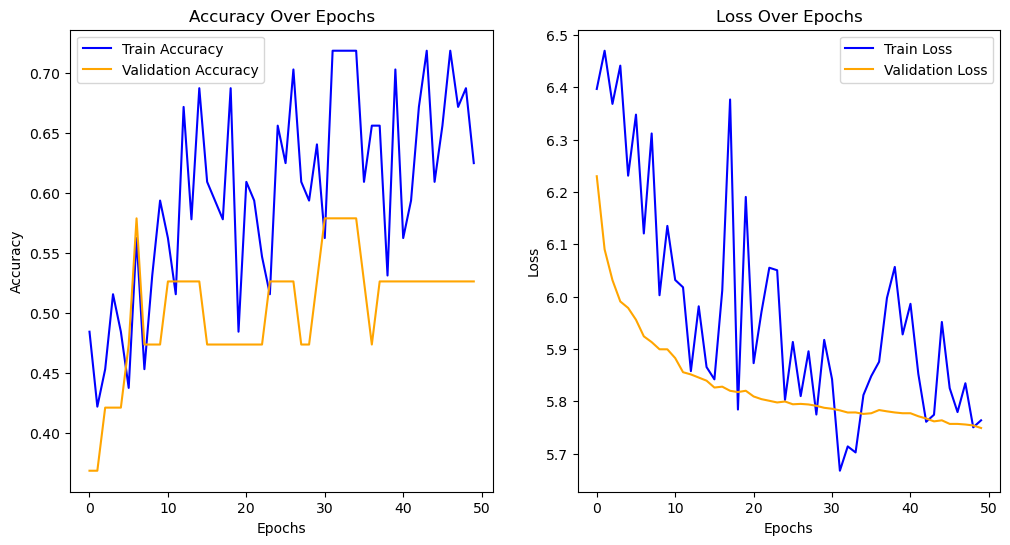

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

dir = "reddit_dataset"

# Paths to the dataset
train_data_dir = f'{dir}/train'  # Replace with your training folder path
test_data_dir = f'{dir}/test'    # Replace with your test folder path

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32  # Reduced batch size for finer gradient updates

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,         # Reduced rotation for better generalization
    width_shift_range=0.3,     # Adjusted horizontal shift
    height_shift_range=0.3,    # Adjusted vertical shift
    shear_range=0.3,           # Adjusted shearing
    zoom_range=0.3,            # Adjusted zoom range
    horizontal_flip=True,
    fill_mode="nearest"
)

# Rescale for validation/testing (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Load MobileNetV2 as the feature extractor
base_model = MobileNetV2(input_shape=(
    IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # Allow fine-tuning

# Freeze all layers except the last 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    # Added L2 regularization
    Dense(256, activation="relu", kernel_regularizer="l2"),
    # Increased dropout rate
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(
    # Reduced learning rate for stability
    optimizer=RMSprop(learning_rate=0.000005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Compute class weights for imbalanced datasets
class_weights = {0: 1.5, 1: 1.0}  # Adjust based on dataset proportions

# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True  # Increased patience
)
model_checkpoint = ModelCheckpoint(
    "reddit_complex_model.h5", monitor="val_loss", save_best_only=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,  # Increased epochs to allow for stabilization
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", color="blue")
plt.plot(history.history["val_accuracy"],
         label="Validation Accuracy", color="orange")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Save the plots
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Save plots dynamically
existing_files = [f for f in os.listdir(output_dir) if f.startswith(
    "training_plot") and f.endswith(".png")]
next_index = max(
    [int(f.split("_")[2].split(".")[0]) for f in existing_files if f.split("_")[2].isdigit()], default=0
) + 1
filename = f"training_plot_{next_index}.png"
plt.savefig(os.path.join(output_dir, filename))

print(f"Training plots saved as {filename} in '{output_dir}'.")

plt.show()

Kagglehub dataset with type of errors on the pcb.

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to organized dataset
train_data_dir = "organized_pcb_data/train"
test_data_dir = "organized_pcb_data/test"

# Check if the dataset is organized correctly
if not os.path.exists(train_data_dir) or not os.path.exists(test_data_dir):
    print("Train and test directories not found. Ensure dataset is organized properly.")
    raise FileNotFoundError("Train or test directory is missing.")

# Debugging dataset structure
print("Train folder contents:", os.listdir(train_data_dir))
for class_dir in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_dir)
    print(f"Class '{class_dir}' contains {len(os.listdir(class_path))} images.")

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # Split training data into train/validation
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",  # Multi-class classification
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Load MobileNetV2 as base model
base_model = MobileNetV2(input_shape=(
    IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    # Adjust classes dynamically
    Dense(len(train_generator.class_indices), activation="softmax")
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    "kaggle_model.h5", monitor="val_loss", save_best_only=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Visualize training results
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

Train folder contents: ['Mouse_bite', 'correct', 'Spur', 'Short', 'Spurious_copper', 'Open_circuit', 'Missing_hole']
Class 'Mouse_bite' contains 88 images.
Class 'correct' contains 8 images.
Class 'Spur' contains 89 images.
Class 'Short' contains 94 images.
Class 'Spurious_copper' contains 100 images.
Class 'Open_circuit' contains 93 images.
Class 'Missing_hole' contains 99 images.
Found 461 images belonging to 7 classes.


Found 110 images belonging to 7 classes.
Found 132 images belonging to 7 classes.
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1590 - loss: 2.3975

15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1588 - loss: 2.3927 - val_accuracy: 0.1818 - val_loss: 1.8669
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1767 - loss: 2.0550 - val_accuracy: 0.1545 - val_loss: 1.9018
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1798 - loss: 1.9070 - val_accuracy: 0.1455 - val_loss: 1.8863
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1113 - loss: 1.9301 - val_accuracy: 0.1545 - val_loss: 1.8732
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2110 - loss: 1.8862

15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2090 - loss: 1.8869 - val_accuracy: 0.2091 - val_loss: 1.8498
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1633 - loss: 1.8839 - val_accuracy: 0.1727 - val_loss: 1.8572
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1602 - loss: 1.8699

15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1607 - loss: 1.8706 - val_accuracy: 0.2364 - val_loss: 1.8453
Epoch 8/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1822 - loss: 1.8960